In [ ]:
#Mounting the drive:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Getting GPU info:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Aug 21 22:08:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Getting usable RAM info:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#PART 1:

• DOMAIN: Face recognition

• CONTEXT: Company X intends to build a face identification model to recognise human faces.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

In [ ]:
#Let us import the initial libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set(style='darkgrid', palette='spring', rc={'figure.figsize':(8,6)})
import string
import os 
import cv2
from google.colab.patches import cv2_imshow

• TASK: 

In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly
interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project.

In [ ]:
#Change to current working directory:
os.chdir('/content/drive/MyDrive/Digital Marketing/ACVproject2')

• Load the dataset and create the metadata.

In [ ]:
#We will directly try to extract images from zip file:
import zipfile

with zipfile.ZipFile('Dataset_Pinterest.zip','r') as zip_ref:
  zip_ref.extractall()

We can manually extract PINS folder too, in case above step is taking too long

In [ ]:
#Lets create functions that will read the image files from extracted zip and put them all in PINS(use the name of folder as metadata):
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

• Check some samples of metadata.

In [ ]:
#Lets check metadata:
metadata

array([PINS/pins_Aaron Paul/Aaron Paul0_262.jpg,
       PINS/pins_Aaron Paul/Aaron Paul101_247.jpg,
       PINS/pins_Aaron Paul/Aaron Paul101_248.jpg, ...,
       PINS/pins_zendaya/zendaya40.jpg, PINS/pins_zendaya/zendaya76.jpg,
       PINS/pins_zendaya/zendaya105.jpg], dtype=object)

In [ ]:
#Define a function to load image from the metadata:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
#Load one image array using the above created function "load_image":
load_image('/content/drive/MyDrive/Digital Marketing/ACVproject2/PINS/pins_Aaron Paul/Aaron Paul7_241.jpg')

array([[[ 91,  36,  16],
        [ 86,  31,  11],
        [ 89,  34,  13],
        ...,
        [ 18,  25,  51],
        [ 17,  24,  50],
        [ 16,  23,  49]],

       [[ 92,  37,  17],
        [ 88,  33,  13],
        [ 88,  33,  12],
        ...,
        [ 18,  25,  51],
        [ 17,  24,  50],
        [ 16,  23,  49]],

       [[ 90,  37,  19],
        [ 89,  37,  16],
        [ 90,  35,  14],
        ...,
        [ 19,  26,  52],
        [ 18,  25,  51],
        [ 17,  24,  50]],

       ...,

       [[187, 100,   3],
        [189, 102,   5],
        [193, 106,   9],
        ...,
        [250, 245, 203],
        [247, 240, 194],
        [247, 239, 190]],

       [[182,  98,   2],
        [184, 100,   4],
        [189, 102,   9],
        ...,
        [252, 244, 198],
        [248, 238, 189],
        [246, 235, 181]],

       [[181,  96,   6],
        [182,  97,   7],
        [185, 100,  10],
        ...,
        [254, 243, 197],
        [248, 236, 184],
        [246, 231, 174]]

• Load the pre-trained model and weights.

In [ ]:
#Here we are giving you the predefined model for VGG face by defining a function with model in it:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
#Loading the model:

model=vgg_face()

In [ ]:
#Getting the summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [ ]:
#Load pretrained vgg face weights from VGG-Face model for Keras(downloaded):
model.load_weights('/content/drive/MyDrive/Digital Marketing/ACVproject2/vgg_face_weights.h5')

In [ ]:
#Get vgg_face_descriptor:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

• Generate Embedding vectors for each face in the dataset.

In [ ]:
#Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model:
# Get embedding vector for first image in the metadata using the pre-trained model:

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]:
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image:
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape :

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [ ]:
embeddings = np.zeros((metadata.shape[0], 2622))
embeddings=[]
for i, m in enumerate(metadata):

  # Get embedding vector for first image in the metadata using the pre-trained model
  img_path = metadata[i].image_path()
  img = load_image(img_path)
  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)
  img = cv2.resize(img, dsize = (224,224))
  print(img.shape)
  # Obtain embedding vector for an image
  # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
  embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  print(embedding_vector.shape)
  embeddings.append(embedding_vector)

Streaming output truncated to the last 5000 lines.
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(224, 224, 3)
(2622,)
(22

In [ ]:
#Checking the second(index1 embedding as a sample):
embeddings[1]

array([ 0.03497703, -0.0010506 , -0.01248935, ..., -0.01053091,
        0.0017932 ,  0.02439154], dtype=float32)

In [ ]:
#Getting the length of all embedding for verifying it with count of total images:
len(embeddings)

10770

• Build distance metrics for identifying the distance between two given images.

In [ ]:
#Define a function to find distance between embeddings:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

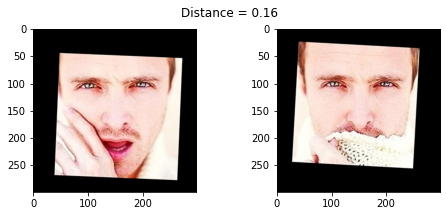

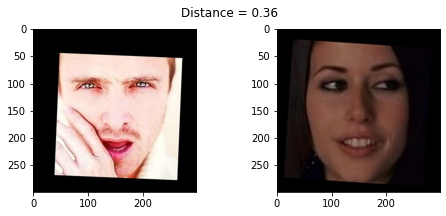

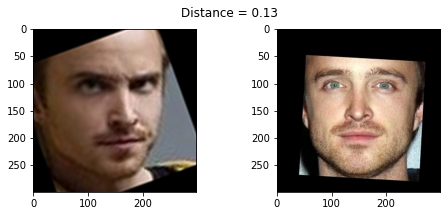

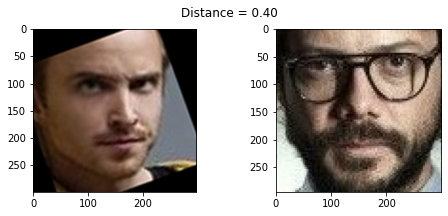

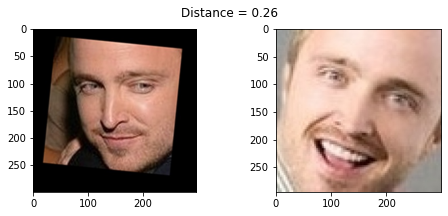

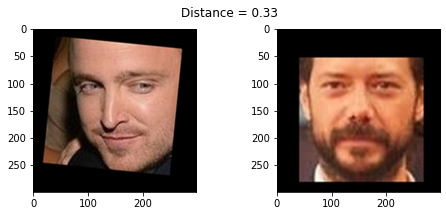

In [ ]:
#Plot images and get distance between the pairs:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

In [ ]:
#Create train and test sets:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities:
# another half as test examples of 10 identities:

X_test=[]
X_train=[]
for i in range(len(embeddings)):
  if i%9==0:
     #print(i)
     X_test.append(embeddings[i])
  else:
     X_train.append(embeddings[i])

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test=targets[test_idx]

In [ ]:
#Checking the length of train data to match:
print(len(X_train),len(y_train))

9573 9573


In [ ]:
#Also check the length of test data:
print(len(X_test),len(y_test))

1197 1197


In [ ]:
#View the y test labels:
y_test

array(['pins_Aaron Paul', 'pins_Aaron Paul', 'pins_Aaron Paul', ...,
       'pins_zendaya', 'pins_zendaya', 'pins_zendaya'], dtype='<U29')

In [ ]:
#Encode target Labels using labelencoder:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train= le.fit_transform(y_train)
Y_test= le.fit_transform(y_test)

In [ ]:
#Standardize the feature values by Scale the features using StandardScaler:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


• Use PCA for dimensionality reduction.

In [ ]:
#Reduce feature dimensions using Principal Component Analysis and Set the parameter n_components=128:

from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [ ]:
#Printing the variance ratio among 128 components:
print(pca.explained_variance_ratio_[:10])

[0.13602928 0.05399449 0.03955416 0.03698497 0.03398418 0.03134932
 0.02596177 0.02352204 0.02104949 0.01937276]


• Build an SVM classifier to map each image to its right person.

In [ ]:
#Since SVM classifier is performing well. Therefore, Grid Search was not performed:
from sklearn.svm import SVC

svm=SVC(random_state=42)
svm.fit(X_train_pca, Y_train)
y_pred = svm.predict(X_test_pca)

In [ ]:
#Getting the accuracy scores of SVM labels:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.9665831244778613


• Predict using the SVM model

Text(0.5, 1.0, 'Predicted as pins_Alvaro Morte and orignial folder name is pins_Alvaro Morte')

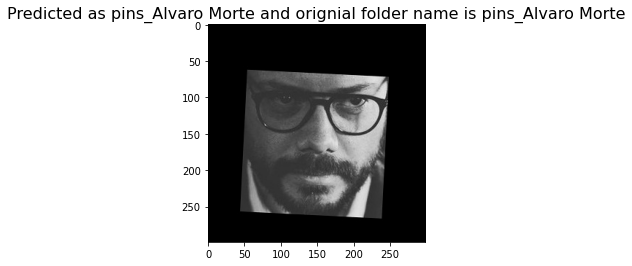

In [ ]:
#Printing a sample predictions from model above:
import warnings # Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())

example_prediction = svm.predict(X_test_pca[[example_idx]])
example_identity = le.inverse_transform(example_prediction)[0]


plt.imshow(example_image)
plt.title('Predicted as '+ example_identity + ' and orignial folder name is ' + y_test[example_idx],fontsize='16') #Since folder name is meta

Text(0.5, 1.0, 'Predicted as Amanda Crew and orignial name is Amanda Crew')

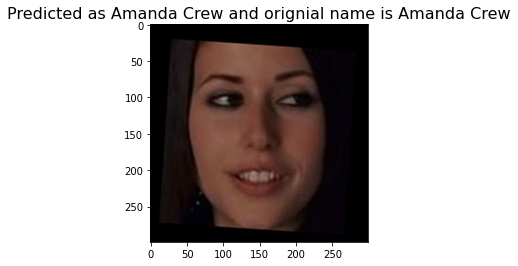

In [ ]:
#Face reconition for another random image:
import warnings # Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 20

example_image = load_image(metadata[test_idx][example_idx].image_path())

example_prediction = y_pred
example_identity = le.inverse_transform(example_prediction)

identity=example_identity[example_idx]

plt.imshow(example_image)
plt.title('Predicted as '+ identity[5:] + ' and orignial name is ' + y_test[example_idx][5:],fontsize='16')

In [ ]:
#Classification Report for SVM Classifier:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#Getting the classification report
print("Classification report for classifier %s:\n%s\n"
      % (svm, metrics.classification_report(Y_test, y_pred,target_names=np.unique(y_test))))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False):
                               precision    recall  f1-score   support

              pins_Aaron Paul       1.00      1.00      1.00        10
            pins_Alvaro Morte       0.91      1.00      0.95        10
             pins_Amanda Crew       1.00      0.92      0.96        13
          pins_Amaury Nolasco       1.00      1.00      1.00        13
               pins_Anna Gunn       1.00      1.00      1.00         7
    pins_Benedict Cumberbatch       1.00      1.00      1.00         9
            pins_Betsy Brandt       1.00      0.88      0.93         8
        pins_Brenton Thwaites       0.88      1.00      0.93        14
            pins_Brit Marling       1.00      1.00      1.00        14
   

In [ ]:
#Confusion Matrix:
n_classes=np.unique(y_test)
print(confusion_matrix(Y_test, y_pred, labels=range(n_classes.shape[0])))

[[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0 11]]


#PART 2:

• DOMAIN: State traffic department

• CONTEXT: City X’s traffic department wants to understand the traffic density on road during busy hours in order to efficiently program
their traffic lights

• TASK: Create an automation using computer vision to impute dynamic bounding boxes to locate cars or vehicles on the road. It would
require for you to do some research on how to impute bounding boxes on video file. You can use video provided with this assignment or
any video of your choice which has moving cars to impute bounding boxes.
Refer to the screenshot from sample video below:

In [ ]:
#Import open CV and colab pactch for imshow(cv2.imshow is disabled for google colab):
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#Import the first video as cap:
cap1 = cv2.VideoCapture('/content/drive/MyDrive/Digital Marketing/ACVproject2/video1.mp4')

In [ ]:
#Create a car cascade classifier using cars.xml downloaded from openCV API for haarcascade:
car_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Digital Marketing/ACVproject2/cars.xml')

In [ ]:
#Lets try using the same haarcascade of opnecv to identify padestrians from second video:
video_src = '/content/drive/MyDrive/Digital Marketing/ACVproject2/video2.mp4'